# Stochastic Swim Meet Simulator

Probabilistic simulator for high school swimming championships using a **Markov performance state** model and **Monte Carlo** simulation.

---

**Notebook outline:**
1. **Load & prep data** — Parse MSHSAA export CSV into swimmers/events.
2. **Performance model** — Markov states (Good/Average/Bad) and time sampling.
3. **Team momentum** — Simple interdependence so strong team results slightly improve later swims.
4. **Event optimization (ILP)** — PuLP-based assignment of swimmers to ≤2 individual events.
5. **Single-meet simulation** — Score one full meet with relays and top-16 points.
6. **Monte Carlo** — Run many meets; get team score distributions and individual results.

Summary: Markov chain per swimmer → Monte Carlo over many meets → outcome distributions (team scores, win probabilities, medal probabilities).


In [240]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns

import matplotlib.pyplot as plt

import pulp

## 1) Load & prep data

Parse the MSHSAA export CSV into a tidy table of swimmers (or relay teams), events, and seed times.

- **Input:** CSV with event names in row 0; then for each event column: place, time, name, school.
- **Output columns:** `name`, `team`, `event`, `best_time` (seconds), `seed_rank`, `is_relay`.


In [241]:
df = pd.read_csv('Girls Swimming Export.csv', header=None)

# Extract event names from first row (skip empty columns)
events = []
event_cols = []
for i in range(0, len(df.columns)-1):
    if i < len(df.columns) and pd.notna(df.iloc[0, i+1]):
        event_name = df.iloc[0, i+1]
        events.append(event_name)
        event_cols.append(i)

In [242]:
events

['200 Medley Relay',
 '200 Freestyle',
 '200 Individual Medley',
 '50 Freestyle',
 '100 Butterfly',
 '100 Freestyle',
 '500 Freestyle',
 '200 Freestyle Relay',
 '100 Backstroke',
 '100 Breaststroke',
 '400 Freestyle Relay']

In [243]:
# Initialize list to store all swimmer records
all_records = []

# Process each event
for event_idx, (event_name, col_start) in enumerate(tqdm(zip(events, event_cols), total=len(events), desc="Processing Events")):
    # Determine if this is a relay event (check if there are swimmer names)
    is_relay = 'Relay' in event_name
    
    # Process each row (starting from row 1, skipping header row 0)
    for row_idx in tqdm(range(1, len(df)), leave=False, desc=f"Event {event_name}"):
        rank = df.iloc[row_idx, col_start - 1]
        time = df.iloc[row_idx, col_start]
        name_or_team = df.iloc[row_idx, col_start + 1]
        team = df.iloc[row_idx, col_start + 2] if not is_relay else name_or_team  # For relays, name_or_team is the team name
        
        # Skip if rank or time is missing
        if pd.isna(rank) or pd.isna(time) or pd.isna(name_or_team):
            continue
        
        # Convert time from MM:SS.SS to total seconds
        if isinstance(time, str) and ':' in time:
            parts = time.split(':')
            total_seconds = float(parts[0]) * 60 + float(parts[1])
        else:
            total_seconds = float(time)
        
        # For individual events
        if not is_relay:
            record = {
                'name': name_or_team,
                'team': team,
                'event': event_name,
                'best_time': total_seconds,
                'seed_rank': int(rank),
                'is_relay': False
            }
            all_records.append(record)
        else:
            # For relay events: team-based, not individual swimmer-based
            record = {
                'name': team,  # For relays, 'name' is the team name
                'team': team,
                'event': event_name,
                'best_time': total_seconds,
                'seed_rank': int(rank),
                'is_relay': True
            }
            all_records.append(record)

# Create DataFrame from records
result_df = pd.DataFrame(all_records)

Processing Events: 100%|██████████| 11/11 [00:00<00:00, 77.69it/s]


In [244]:
result_df.sample(5)

,name,team,event,best_time,seed_rank,is_relay
875,Warrensburg,Warrensburg,200 Freestyle Relay,118.83,71,True
960,Audrie Hanway,Lee's Summit,100 Backstroke,67.14,69,False
686,Claire Porter,Blue Springs South,100 Freestyle,60.11,127,False
989,Molly Moriarty,Visitation Academy,100 Breaststroke,69.49,10,False
636,Kayla Wahl,Cor Jesu Academy,100 Freestyle,58.58,77,False


### 1.1 Class split and data prep

Load performance data by class, merge school/class info, reseed ranks within class+event, and filter to Class 1 for simulation.


In [245]:
swimmers = pd.read_csv("swimming_performance.csv")
schools = pd.read_csv("school_class_assignments.csv")

# Merge Class info into swimmer table
swimmers = swimmers.merge(
    schools[['School', 'Class']],
    left_on='team',
    right_on='School',
    how='left',
    validate='m:1'
).drop(columns=['School'])

In [246]:
swimmers.sample(5)

,name,team,event,best_time,seed_rank,is_relay,Class
295,Kayla Wahl,Cor Jesu Academy,200 IM,2:16.83,18,False,2
772,Sarah Miner,Rock Bridge,100 Free,56.38,26,False,2
1051,Olive Agustin,Clayton,500 Free,5:57.15,54,False,1
679,Ella Paul,Rockwood Summit,100 Fly,1:05.78,42,False,1
755,Cecilia Hoganson,Kirkwood,100 Free,55.72,17,False,2


In [247]:
def convert_swim_time(time_str):
    """
    Convert swimming time string to decimal seconds and return as float.
    Also provides a string representation in consistent format.
    """
    if pd.isna(time_str) or not isinstance(time_str, str):
        return np.nan, ""
    
    time_str = time_str.strip()
    if not time_str:
        return np.nan, ""
    
    try:
        parts = time_str.split(':')
        
        if len(parts) == 1:
            # Format: "57.04"
            seconds = float(parts[0])
            # Format as MM:SS.mm if over 60 seconds
            if seconds >= 60:
                minutes = int(seconds // 60)
                remaining_seconds = seconds % 60
                formatted = f"{minutes}:{remaining_seconds:05.2f}"
            else:
                formatted = f"{seconds:.2f}"
            return seconds, formatted
        
        elif len(parts) == 2:
            # Format: "1:46.57"
            minutes = float(parts[0])
            seconds = float(parts[1])
            total_seconds = minutes * 60 + seconds
            
            # Format consistently
            if minutes > 0:
                formatted = f"{int(minutes)}:{seconds:05.2f}"
            else:
                formatted = f"{seconds:.2f}"
            
            return total_seconds, formatted
        
        elif len(parts) == 3:
            # Format: "1:02:34.56" - rare for high school swimming
            hours = float(parts[0])
            minutes = float(parts[1])
            seconds = float(parts[2])
            total_seconds = hours * 3600 + minutes * 60 + seconds
            
            # Format consistently
            if hours > 0:
                formatted = f"{int(hours)}:{int(minutes):02d}:{seconds:05.2f}"
            elif minutes > 0:
                formatted = f"{int(minutes)}:{seconds:05.2f}"
            else:
                formatted = f"{seconds:.2f}"
            
            return total_seconds, formatted
        
        else:
            return np.nan, time_str
            
    except (ValueError, AttributeError):
        return np.nan, time_str

# Function to apply to a DataFrame
def add_time_seconds_column(df, time_col='best_time'):
    """
    Add a column with time converted to decimal seconds.
    Also adds a formatted time column for consistency.
    """
    # Apply conversion function
    results = df[time_col].apply(lambda x: convert_swim_time(x) if pd.notna(x) else (np.nan, ""))
    
    # Extract seconds and formatted times
    df[time_col] = [result[0] for result in results]
    df['time_formatted'] = [result[1] for result in results]
    
    return df

In [248]:
add_time_seconds_column(swimmers)

,name,team,event,best_time,seed_rank,is_relay,Class,time_formatted
0,St. Joseph's Academy,St. Joseph's Academy,200 Medley Relay,106.57,1,True,2,1:46.57
1,Park Hill South,Park Hill South,200 Medley Relay,108.32,2,True,2,1:48.32
2,Rock Bridge,Rock Bridge,200 Medley Relay,108.68,3,True,2,1:48.68
3,Visitation Academy,Visitation Academy,200 Medley Relay,110.53,1,True,1,1:50.53
4,Kirkwood,Kirkwood,200 Medley Relay,110.84,4,True,2,1:50.84
...,...,...,...,...,...,...,...,...
1493,Belton,Belton,400 Free Relay,269.98,41,True,1,4:29.98
1494,Ft. Zumwalt East,Ft. Zumwalt East,400 Free Relay,270.65,42,True,1,4:30.65
1495,Central (Springfield),Central (Springfield),400 Free Relay,272.19,43,True,1,4:32.19
1496,Washington,Washington,400 Free Relay,273.16,44,True,1,4:33.16


In [249]:
# Sort by class, then event, then best_time ascending (faster = smaller time); tie-break by name
swimmers = swimmers.sort_values(
    ["Class", "event", "best_time", "name"], ascending=[True, True, True, True])
# Recompute seed_rank within each Class+event
swimmers["seed_rank"] = swimmers.groupby(["Class", "event"]).cumcount() + 1

In [250]:
class1_swimmers = swimmers[swimmers['Class'] == 1]
class2_swimmers = swimmers[swimmers['Class'] == 2]

In [251]:
result_df = class1_swimmers

In [252]:
result_df.head(10)

,name,team,event,best_time,seed_rank,is_relay,Class,time_formatted
1167,Karsynne McAlister,Central (Cape Girardeau),100 Back,56.30,1,False,1,56.30
1168,Gracey MacLaughlin,Louisiana,100 Back,57.04,2,False,1,57.04
1170,Madelyn Mug,Visitation Academy,100 Back,57.94,3,False,1,57.94
1175,Ann Erwin,Webster Groves,100 Back,59.57,4,False,1,59.57
1179,Ella Paul,Rockwood Summit,100 Back,60.02,5,False,1,1:00.02
1181,Polly Fendler,St. Teresa's Academy,100 Back,60.39,6,False,1,1:00.39
1182,Olivia Deberge,Timberland,100 Back,60.86,7,False,1,1:00.86
1184,Charlotte Leary,Villa Duchesne,100 Back,60.93,8,False,1,1:00.93
1185,Jane Hill,Villa Duchesne,100 Back,61.10,9,False,1,1:01.10
1186,Charlotte Brown,Villa Duchesne,100 Back,61.11,10,False,1,1:01.11


## 2) Performance model (w/ MCMC!)
I model each swimmer's resulting time using Markov Chain Monte Carlo (MCMC). This best simulates how a swimmer might perform at a specific meet because each swimmer has a performance state *(Good / Average / Bad)* and I add noise of +/- 0.5% or ~0.2s to every outcome.

**To explain the Markov Chain part more:** Swimmers move between these states in their events as the simulated swim meet goes on.
| State   | Time Adjustment      |
| ------- | -------------------- |
| Good    | 0.98 × personal best |
| Average | 1.00 × personal best |
| Bad     | 1.03 × personal best |

These are the transition probabilities of moving between states:
| From → To   | Good | Average | Bad |
| ----------- | ---- | ------- | --- |
| **Good**    | 0.7  | 0.2     | 0.1 |
| **Average** | 0.3  | 0.5     | 0.2 |
| **Bad**     | 0.1  | 0.3     | 0.6 |

Ex. If a swimmer is in the Good state right now, they have:
- a 70% chance to stay Good in the next event,
- a 20% chance to slip to Average,
- a 10% chance to have a Bad race.

Note how it's stochastic, meaning that you don't know the exact outcome but you know the distribution. This is to capture the concept of a swimmer having a 'good' or 'bad' day or race and how that affects other events

**To explain the Monte Carlo part more:** each meet = 1 Monte Carlo trial & a swimmer's performance state will be tested for each meet as well. Each swimmer's time is a random draw from a normal distribution that's centered around their performance state at that time, which should add +/- 0.5% or ~0.2s variability. I will also run the simulation thousands of times to sample it again and again to get a representation of the probabilities & chains.

In [253]:
PERF_STATES = ['Good','Average','Bad']

transition_matrix = {
    'Good': {'Good':0.7,'Average':0.25,'Bad':0.05},
    'Average': {'Good':0.15,'Average':0.7,'Bad':0.15},
    'Bad': {'Good':0.05,'Average':0.25,'Bad':0.7}
}

sigma_mult = {'Good':0.005, 'Average':0.01, 'Bad':0.02}

In [254]:
def step_state(current_state):
    probs = list(transition_matrix[current_state].values())
    next_state = np.random.choice(list(transition_matrix[current_state].keys()), p=probs)
    return next_state

def sample_time(best_time, state):
    sigma = best_time * sigma_mult[state]
    return np.random.normal(best_time, sigma)


## 3) Adaptive interdependence (team momentum)

I also added a simple **team momentum** effect, which is where if earlier events produce unexpectedly good results for a team, later swimmers from the same team also have a small time improvement. This was pretty simple and I can add more sophistication later (fatigue, lane number effects, head-to-head racing, etc.)

In [255]:
def apply_team_momentum(team_scores_by_event, base_time, team, momentum_factor=0.001):
    # team_scores_by_event: dict tracking cumulative unexpected_points (or performance) per team so far
    # base_time: best_time
    # momentum_factor: seconds improvement per unit of team momentum
    momentum = team_scores_by_event.get(team, 0.0)
    adjusted_time = base_time - (momentum * momentum_factor)
    return adjusted_time

## 4) Event optimization (ILP)

Use **PuLP** to assign each swimmer to at most 2 individual events to maximize expected team points.

- **Objective:** Maximize sum of expected points (from seed rank).
- **Variables:** Binary \(x[swimmer, event]\) = 1 if swimmer enters that event.
- **Constraints:** Each swimmer ≤ 2 events; each event has 16 swimmers; conflict pairs (e.g. 200 Free & 200 IM) mutually exclusive.


In [256]:
POINTS = [20,17,16,15,14,13,12,11,9,7,6,5,4,3,2,1]

def seed_to_points(rank):
    if rank <= 16:
        return POINTS[rank-1]
    else:
        return 16 / rank

def optimize_event_assignments(df, max_events_per_swimmer=2, swimmers_per_event=32, max_swimmers_per_school_per_event=4):
    """
    ILP: assign each individual to 1-2 events. Maximize top individuals' best events first, then fill rest.
    Priority weight = expected_points * (1000 for swimmer's best event, 100 for 2nd best, 1 for rest).
    - Each event gets exactly target (32 or less) swimmers.
    - At most 4 per school per event.
    - Within each (school, event), chosen swimmers must be top k by seed rank (fairness).
    - Conflict pairs: same swimmer cannot do both (e.g. 100 Back & 100 Breast).
    """
    df = df.copy()
    df = df.drop_duplicates(subset=["name", "event"]).reset_index(drop=True)
    df["expected_points"] = df["seed_rank"].apply(seed_to_points)
    # Priority weight: put each swimmer in their best events first (rank 1 = best, 2 = second, etc.; ties by seed_rank then event)
    df = df.sort_values(["name", "expected_points", "seed_rank", "event"], ascending=[True, False, True, True]).reset_index(drop=True)

    swimmers = df["name"].unique()
    events = df["event"].unique()
    
    model = pulp.LpProblem("SwimMeetOptimization", pulp.LpMaximize)
    x = pulp.LpVariable.dicts(
        "x", ((r["name"], r["event"]) for _, r in df.iterrows()), cat="Binary"
    )
    
    # Objective: maximize priority-weighted points (top individuals in their best events first, then fill rest)
    model += pulp.lpSum(r["expected_points"] * x[(r["name"], r["event"])] for _, r in df.iterrows())
    
    # Each swimmer: at most 2 events (sum each event once per swimmer)
    for s in swimmers:
        events_for_s = df[df["name"] == s]["event"].unique()
        model += pulp.lpSum(x[(s, e)] for e in events_for_s) <= max_events_per_swimmer
    
    # Per-school cap per event
    if "team" in df.columns:
        for e in events:
            event_df = df[df["event"] == e]
            for team in event_df["team"].unique():
                team_rows = event_df[event_df["team"] == team]
                model += pulp.lpSum(x[(r["name"], e)] for _, r in team_rows.iterrows()) <= max_swimmers_per_school_per_event
    
    # Each event: exactly target swimmers (32 or max possible given per-school cap)
    for e in events:
        event_swimmers = df[df["event"] == e]
        if "team" in df.columns:
            max_possible = sum(
                min(max_swimmers_per_school_per_event, len(event_swimmers[event_swimmers["team"] == t]))
                for t in event_swimmers["team"].unique()
            )
            target = min(swimmers_per_event, max_possible, len(event_swimmers))
        else:
            target = min(swimmers_per_event, len(event_swimmers))
        model += pulp.lpSum(x[(r["name"], e)] for _, r in event_swimmers.iterrows()) == target
    
    # Conflict pairs: same swimmer cannot do both
    conflict_pairs = [
        ("200 Free", "200 IM"), ("200 Freestyle", "200 IM"),
        ("50 Free", "200 IM"), ("50 Freestyle", "200 IM"),
        ("100 Free", "100 Fly"), ("100 Freestyle", "100 Butterfly"),
        ("100 Back", "100 Breast"), ("100 Backstroke", "100 Breaststroke"),
        ("500 Free", "100 Free"), ("500 Freestyle", "100 Freestyle"),
    ]
    for s in swimmers:
        swimmer_events = set(df[df["name"] == s]["event"].unique())
        for e1, e2 in conflict_pairs:
            if e1 in swimmer_events and e2 in swimmer_events:
                model += x[(s, e1)] + x[(s, e2)] <= 1
    
    model.solve(pulp.PULP_CBC_CMD(msg=False))
    
    selected_rows = [r for _, r in df.iterrows() if pulp.value(x[(r["name"], r["event"])]) > 0.5]
    selected = pd.DataFrame(selected_rows)
    # No ties: rank by best_time then name, assign unique 1,2,3,... per event
    selected = selected.sort_values(["event", "best_time", "name"]).reset_index(drop=True)
    selected["new_seed_rank"] = selected.groupby("event").cumcount() + 1
    return selected

In [257]:
output = optimize_event_assignments(class1_swimmers)
output.to_csv("class1_assignments.csv")

## 5) Single-meet simulation

Simulate one full meet: run each event in order, sample times from the Markov model (with team momentum), rank by time, and assign top-16 points. Relays use the same points scale but **double** points.

In [258]:
POINTS = [20,17,16,15,14,13,12,11,9,7,6,5,4,3,2,1]  # assign to places 1..16

def simulate_one_meet(df, assignments, relay_assignments=None, verbose=False):
    # df: DataFrame rows: name, team, event, best_time, is_relay
    # assignments: dict mapping swimmer -> list of events they're entered (enforces <=2 events)
    # relay_assignments: dict mapping team -> list of relay events they're entered in
    # returns: dataframe of results and team scores
    
    # initialize states for each swimmer randomly (or all Average)
    swimmer_states = {name: np.random.choice(PERF_STATES, p=[0.2,0.6,0.2]) for name in df[df['is_relay']==False]['name'].unique()}
    
    # For relays, use team-based states
    team_relay_states = {team: np.random.choice(PERF_STATES, p=[0.2,0.6,0.2]) for team in df[df['is_relay']==True]['team'].unique()}
    
    results = []
    # track team 'unexpectedness' as sum of (expected_rank - actual_rank) positive values
    team_momentum = {}
    
    # Build event list: use df order but ensure every individual event from assignments is included
    # (simulate both events per swimmer even if df.event.unique() order or content differs)
    events_from_df = df['event'].unique().tolist()
    events_from_assignments = sorted(set(e for evs in assignments.values() for e in evs))
    events_order = list(events_from_df)
    for e in events_from_assignments:
        if e not in events_order:
            events_order.append(e)
    
    for event in events_order:
        # Check if this is a relay event
        event_rows = df[df['event'] == event]
        is_relay = event_rows['is_relay'].iloc[0] if len(event_rows) > 0 else False
        
        if is_relay:
            # Handle relay events (team-based)
            if relay_assignments is None:
                # If no relay assignments provided, use all teams that have this relay in df
                entrants = event_rows['team'].unique().tolist()
            else:
                # Use relay assignments
                entrants = [team for team, evs in relay_assignments.items() if event in evs]
            
            rows = df[df['team'].isin(entrants) & (df['event']==event)]
            
            sim_rows = []
            for _, r in rows.iterrows():
                team = r['team']; base = r['best_time']
                # step state for team relay performance
                cur_state = team_relay_states.get(team, 'Average')
                next_state = step_state(cur_state)
                team_relay_states[team] = next_state
                # apply team momentum to base time
                adj_base = apply_team_momentum(team_momentum, base, team)
                time = sample_time(adj_base, next_state)
                sim_rows.append({'name':team,'team':team,'event':event,'time':time,'state':next_state,'is_relay':True})
        else:
            # Handle individual events (each swimmer can be in up to 2 events)
            entrants = [s for s, evs in assignments.items() if event in evs]
            rows = df[df['name'].isin(entrants) & (df['event']==event)]
            # If no rows, event might be named differently in df; try exact match on event column
            if rows.empty and entrants:
                ev_in_df = [e for e in df['event'].unique() if str(e).strip() == str(event).strip()]
                if ev_in_df:
                    rows = df[df['name'].isin(entrants) & (df['event']==ev_in_df[0])]
            
            sim_rows = []
            for _, r in rows.iterrows():
                name = r['name']; team = r['team']; base = r['best_time']
                # step state to model carryover between events for the swimmer
                cur_state = swimmer_states.get(name, 'Average')
                next_state = step_state(cur_state)
                swimmer_states[name] = next_state
                # apply team momentum to base time
                adj_base = apply_team_momentum(team_momentum, base, team)
                time = sample_time(adj_base, next_state)
                sim_rows.append({'name':name,'team':team,'event':event,'time':time,'state':next_state,'is_relay':False})
        
        # rank by time and assign points
        if not sim_rows:
            continue
        sim_df = pd.DataFrame(sim_rows).sort_values('time').reset_index(drop=True)
        sim_df['place'] = sim_df.index + 1
        
        # Relays get DOUBLE points
        if is_relay:
            sim_df['points'] = sim_df['place'].apply(lambda p: POINTS[p-1] * 2 if p<=len(POINTS) else 0)
        else:
            sim_df['points'] = sim_df['place'].apply(lambda p: POINTS[p-1] if p<=len(POINTS) else 0)
        
        # update team momentum: if a swimmer/team beats expectation (seed_rank) by a margin, increase momentum
        for i, row in sim_df.iterrows():
            name = row['name']; team = row['team']; place = row['place']
            seed_row = df[(df['name']==name)&(df['event']==event)]
            if not seed_row.empty:
                seed_rank = int(seed_row['seed_rank'].iloc[0])
                unexpected = max(0, seed_rank - place)
                team_momentum[team] = team_momentum.get(team, 0.0) + unexpected * 0.2  # tuning parameter
        results.append(sim_df)
    
    full = pd.concat(results, ignore_index=True) if results else pd.DataFrame(columns=['name','team','event','time','place','points','is_relay'])
    team_scores = full.groupby('team')['points'].sum().to_dict()
    return full, team_scores

## 6) Monte Carlo simulation

Run many simulated meets to get distributions of team scores and individual results. Returns two DataFrames: **`df_scores`** (team total per sim) and **`df_results`** (per swimmer/event per sim).


In [259]:
def run_monte_carlo(df, assignments, relay_assignments=None, n_sims=2000):
    """
    Run Monte Carlo simulations and collect both team scores and individual swimmer results.
    Returns two DataFrames: (df_team_scores, df_swimmer_results).
    - df_team_scores: columns [simulation_id, team, points] — one row per team per simulation.
    - df_swimmer_results: full per-event results with simulation_id (name, team, event, time, state, is_relay, place, points, simulation_id).
    """
    team_scores_rows = []
    all_results = []
    
    for i in tqdm(range(n_sims), desc="Running Monte Carlo simulations"):
        full, team_scores = simulate_one_meet(df, assignments, relay_assignments)
        
        full = full.copy()
        full["simulation_id"] = i
        all_results.append(full)
        
        for team, score in team_scores.items():
            team_scores_rows.append({"simulation_id": i, "team": team, "points": score})
    
    df_team_scores = pd.DataFrame(team_scores_rows)
    df_swimmer_results = pd.concat(all_results, ignore_index=True)
    return df_team_scores, df_swimmer_results

In [260]:
# Build individual event assignments (ILP) and relay assignments
assignments_dict = optimize_event_assignments(result_df[result_df['is_relay']==False])
# Group by swimmer so each gets a list of 1 or 2 events (dict comp overwrote when same swimmer had 2)
assignments = assignments_dict.groupby('name')['event'].apply(list).to_dict()

relay_assignments = {}
for team in result_df[result_df['is_relay']==True]['team'].unique():
    relay_events = result_df[(result_df['team']==team) & (result_df['is_relay']==True)]['event'].tolist()
    if relay_events:
        relay_assignments[team] = relay_events

print(f"Individual event assignments: {len(assignments)} swimmers")
print(f"Relay assignments: {len(relay_assignments)} teams")

Individual event assignments: 144 swimmers
Relay assignments: 60 teams


In [261]:
assignments['Reese Anderson']

['100 Free', '200 Free']

### 6.1 Event assignments

Build individual event assignments (ILP) and relay assignments from the result DataFrame.


In [262]:
number_sims = 100
df_scores, df_results = run_monte_carlo(result_df,
                                        assignments,
                                        relay_assignments,
                                        n_sims=number_sims)

Running Monte Carlo simulations: 100%|██████████| 100/100 [00:13<00:00,  7.51it/s]


In [263]:
# df_results.to_csv('class1_swimmer_results.csv', index=False)
# df_scores.to_csv('class1_team_scores.csv', index=False)

### 6.3 Outputs: two DataFrames

- **`df_scores`**: `simulation_id`, `team`, `points` — one row per team per simulation (total score).
- **`df_results`**: per-event results with `simulation_id`, `name`, `team`, `event`, `time`, `state`, `is_relay`, `place`, `points` — one row per swimmer-event per simulation.

Use `df_scores` for team stats and win probabilities; use `df_results` for individual and medal analysis.


### 6.2 Run Monte Carlo (quick check)

Run a small number of simulations (e.g. 100) to inspect outputs before a full run.


In [264]:
# df_scores and df_results come directly from run_monte_carlo
print(f"Total simulations: {df_scores['simulation_id'].nunique()}")
print(f"Total teams: {df_scores['team'].nunique()}")
print(f"\nSample a few rows (team scores):")
df_scores.sample(10)

Total simulations: 100
Total teams: 62

Sample a few rows (team scores):


,simulation_id,team,points
3395,54,St. Charles West,0
3085,49,St. Charles West,0
1064,17,Ft. Zumwalt South,15
2042,32,Washington,0
5208,84,Belton,0
758,12,Greenwood,8
2578,41,Notre Dame de Sion,61
3735,60,Hannibal,0
3929,63,Lebanon,27
3043,49,Central (Cape Girardeau),56


In [265]:
# Calculate summary statistics for each team
team_stats = df_scores.groupby('team')['points'].agg([
    ('mean', 'mean'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max'),
    ('median', 'median'),
    ('q25', lambda x: x.quantile(0.25)),
    ('q75', lambda x: x.quantile(0.75))
]).round(1)

team_stats = team_stats.sort_values('mean', ascending=False)
print("Team Performance Statistics (sorted by average points):")
team_stats


Team Performance Statistics (sorted by average points):


,mean,std,min,max,median,q25,q75
team,,,,,,,
Parkway Central,233.7,10.3,207,255,235.0,228.0,240.0
Visitation Academy,152.8,8.7,133,181,152.0,148.0,158.0
St. Teresa's Academy,152.2,10.2,123,171,153.0,146.0,159.0
Villa Duchesne,148.8,11.7,112,184,150.0,141.0,156.0
Webster Groves,148.2,12.5,110,179,150.0,143.8,155.0
...,...,...,...,...,...,...,...
Holt,0.0,0.0,0,0,0.0,0.0,0.0
New Covenant Academy,0.0,0.0,0,0,0.0,0.0,0.0
Jefferson City,0.0,0.0,0,0,0.0,0.0,0.0


In [266]:
# Calculate placement probabilities
total_simulations = df_scores['simulation_id'].nunique()

# Add rank column (1st = highest points)
df_scores['rank'] = df_scores.groupby('simulation_id')['points'].rank(ascending=False, method='first')

# Create results dictionary
results = {}
for team in df_scores['team'].unique():
    team_data = df_scores[df_scores['team'] == team]
    results[team] = {
        'team': team,
        'place_1%': (team_data['rank'] == 1).sum() / total_simulations * 100,
        'place_2%': (team_data['rank'] == 2).sum() / total_simulations * 100,
        'place_3%': (team_data['rank'] == 3).sum() / total_simulations * 100,
        'place_4%': (team_data['rank'] == 4).sum() / total_simulations * 100,
    }

# Convert to DataFrame
prob_df = pd.DataFrame(results.values())

# For swimming: podium = top 4 finishers
prob_df['podium%'] = prob_df['place_1%'] + prob_df['place_2%'] + prob_df['place_3%'] + prob_df['place_4%']

# Sort by 1st place probability (then by podium probability as tiebreaker)
prob_df = prob_df.sort_values(['place_1%', 'podium%'], ascending=False).reset_index(drop=True)

print(f"top 10 place probabilities ({total_simulations} simulations)")
# which team won each simulation?
prob_df.round(2).head(10)

top 10 place probabilities (100 simulations)


,team,place_1%,place_2%,place_3%,place_4%,podium%
0,Parkway Central,100.0,0.0,0.0,0.0,100.0
1,Visitation Academy,0.0,19.0,30.0,25.0,74.0
2,St. Teresa's Academy,0.0,31.0,21.0,20.0,72.0
3,Webster Groves,0.0,15.0,25.0,19.0,59.0
4,Villa Duchesne,0.0,22.0,14.0,22.0,58.0
5,Father Tolton,0.0,13.0,10.0,14.0,37.0
6,Belton,0.0,0.0,0.0,0.0,0.0
7,Bolivar,0.0,0.0,0.0,0.0,0.0
8,Camdenton,0.0,0.0,0.0,0.0,0.0
9,Capital City,0.0,0.0,0.0,0.0,0.0


### 6.4 Team score statistics and win probabilities

Summarize team score distributions and compute win and placement probabilities from `df_scores`.


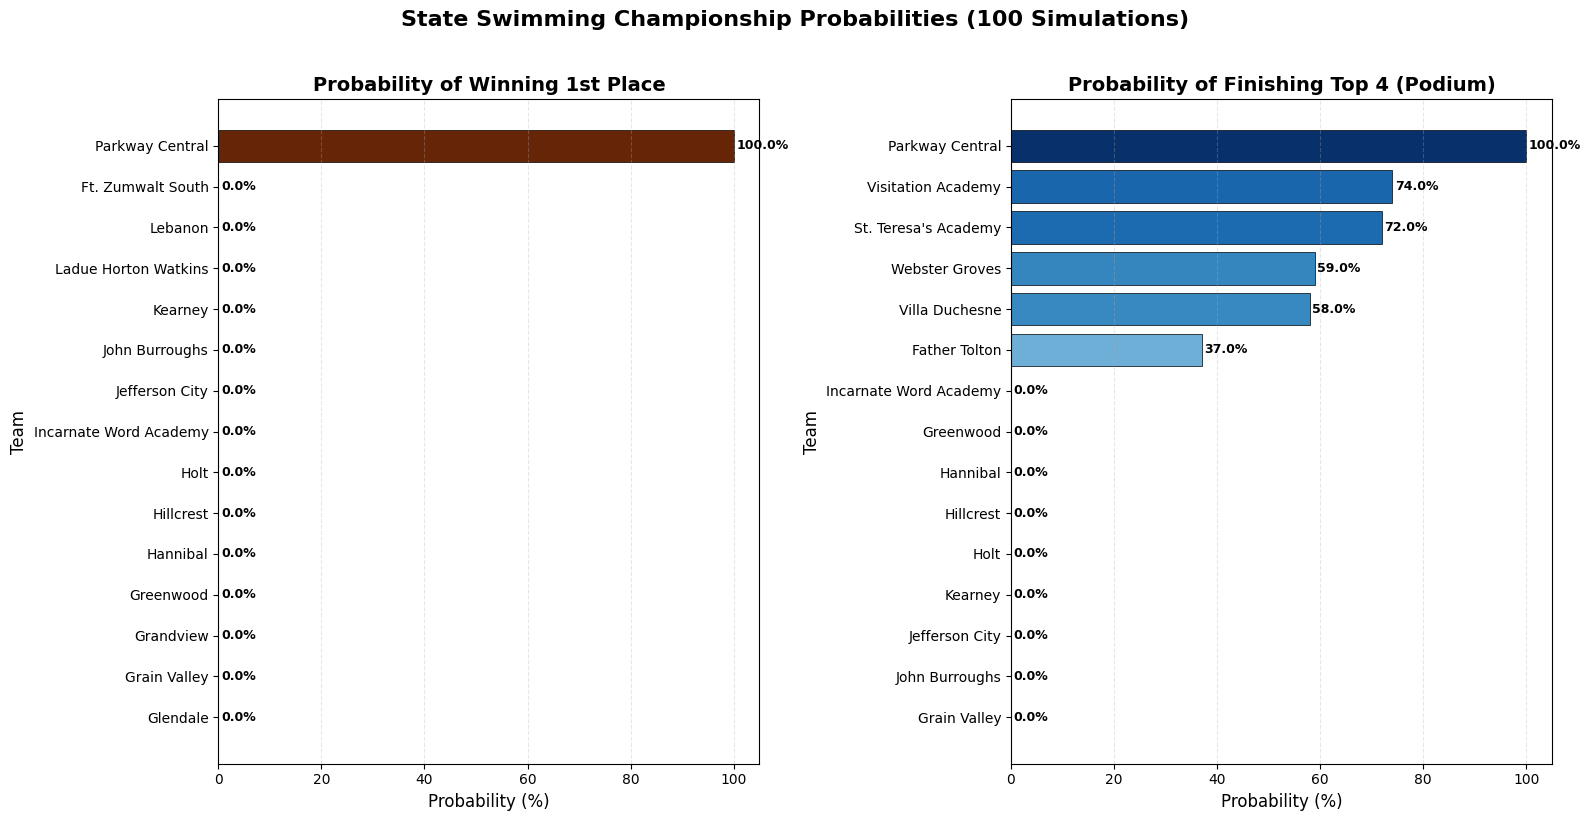

In [267]:
# Create visualization for placement probabilities
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 1. First Place Probabilities (Horizontal Bar Chart)
ax1 = axes[0]
first_place_sorted = prob_df.sort_values('place_1%', ascending=True).tail(15)  # Top 15 teams

# Create gradient colors based on probability
colors_1st = plt.cm.YlOrBr((first_place_sorted['place_1%'] / first_place_sorted['place_1%'].max()) * 0.8 + 0.2)

bars1 = ax1.barh(range(len(first_place_sorted)), 
                 first_place_sorted['place_1%'], 
                 color=colors_1st, 
                 edgecolor='black', 
                 linewidth=0.5)

ax1.set_yticks(range(len(first_place_sorted)))
ax1.set_yticklabels(first_place_sorted['team'])
ax1.set_title("Probability of Winning 1st Place", fontsize=14, fontweight='bold')
ax1.set_xlabel("Probability (%)", fontsize=12)
ax1.set_ylabel("Team", fontsize=12)
ax1.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar, prob) in enumerate(zip(bars1, first_place_sorted['place_1%'])):
    width = bar.get_width()
    ax1.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{prob:.1f}%', va='center', fontsize=9, fontweight='bold')

# 2. Top 4 (Podium) Probabilities (Horizontal Bar Chart)
ax2 = axes[1]
podium_sorted = prob_df.sort_values('podium%', ascending=True).tail(15)  # Top 15 teams

# Create gradient colors based on probability (blues for podium)
colors_podium = plt.cm.Blues((podium_sorted['podium%'] / podium_sorted['podium%'].max()) * 0.8 + 0.2)

bars2 = ax2.barh(range(len(podium_sorted)), 
                 podium_sorted['podium%'], 
                 color=colors_podium, 
                 edgecolor='black', 
                 linewidth=0.5)

ax2.set_yticks(range(len(podium_sorted)))
ax2.set_yticklabels(podium_sorted['team'])
ax2.set_title("Probability of Finishing Top 4 (Podium)", fontsize=14, fontweight='bold')
ax2.set_xlabel("Probability (%)", fontsize=12)
ax2.set_ylabel("Team", fontsize=12)
ax2.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar, prob) in enumerate(zip(bars2, podium_sorted['podium%'])):
    width = bar.get_width()
    ax2.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{prob:.1f}%', va='center', fontsize=9, fontweight='bold')

plt.suptitle(f"State Swimming Championship Probabilities ({total_simulations} Simulations)", 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

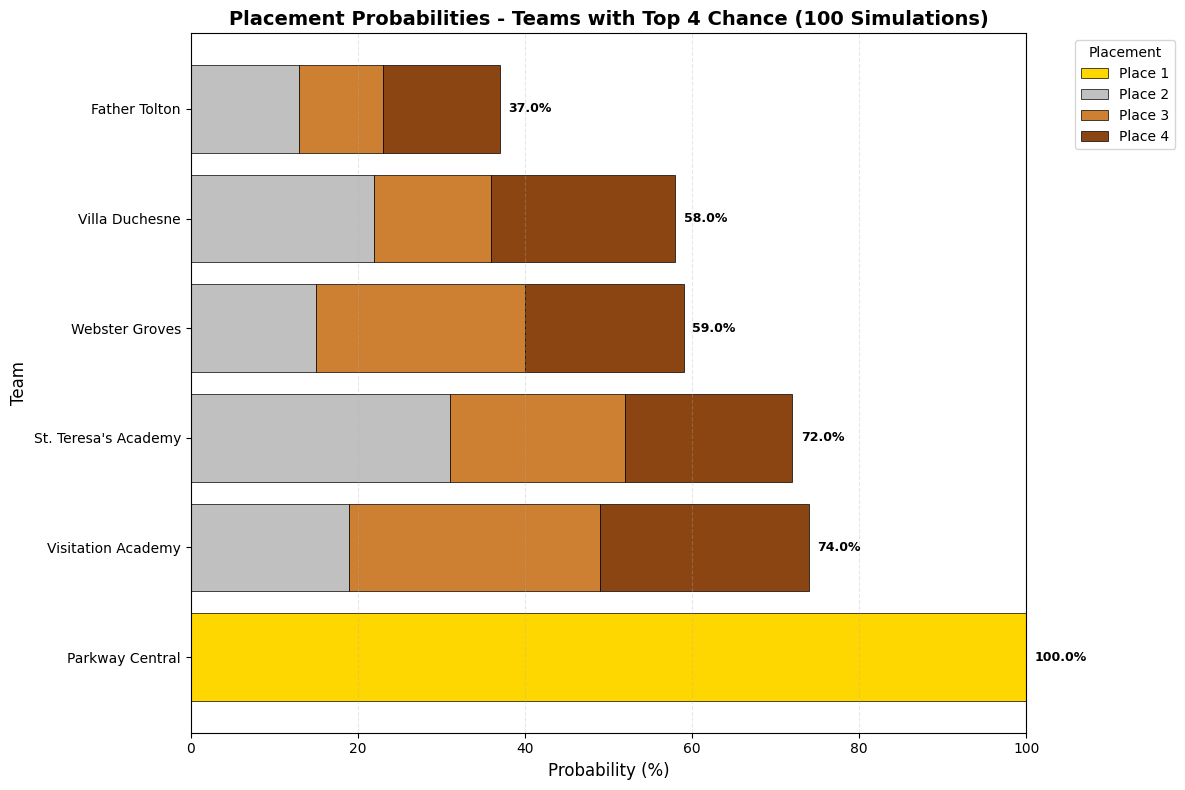

In [268]:
# Filter teams that have ANY chance of making top 4 (1st, 2nd, 3rd, or 4th)
teams_with_top4_chance = prob_df[
    (prob_df['place_1%'] > 0) | 
    (prob_df['place_2%'] > 0) | 
    (prob_df['place_3%'] > 0) | 
    (prob_df['place_4%'] > 0)
].copy()

# Take top 10 teams from those with top 4 chance (or fewer if less than 10)
top_teams = teams_with_top4_chance.head(10).copy()

fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for each placement
placement_colors = {
    'place_1%': '#FFD700',  # Gold
    'place_2%': '#C0C0C0',  # Silver
    'place_3%': '#CD7F32',  # Bronze
    'place_4%': '#8B4513',  # Brown
}

# Create stacked bars
bottom = np.zeros(len(top_teams))
for placement, color in placement_colors.items():
    values = top_teams[placement].values
    ax.barh(range(len(top_teams)), values, left=bottom, 
            color=color, edgecolor='black', linewidth=0.5, 
            label=placement.replace('%', '').replace('_', ' ').title())
    bottom += values

ax.set_yticks(range(len(top_teams)))
ax.set_yticklabels(top_teams['team'])
ax.set_xlabel("Probability (%)", fontsize=12)
ax.set_ylabel("Team", fontsize=12)
ax.set_title(f"Placement Probabilities - Teams with Top 4 Chance ({total_simulations} Simulations)", 
                fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.legend(title="Placement", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add total probability labels
for i, (team, total_prob) in enumerate(zip(top_teams['team'], top_teams['podium%'])):
    if total_prob > 0:  # Only add label if there's any probability
        ax.text(total_prob + 1, i, f'{total_prob:.1f}%', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

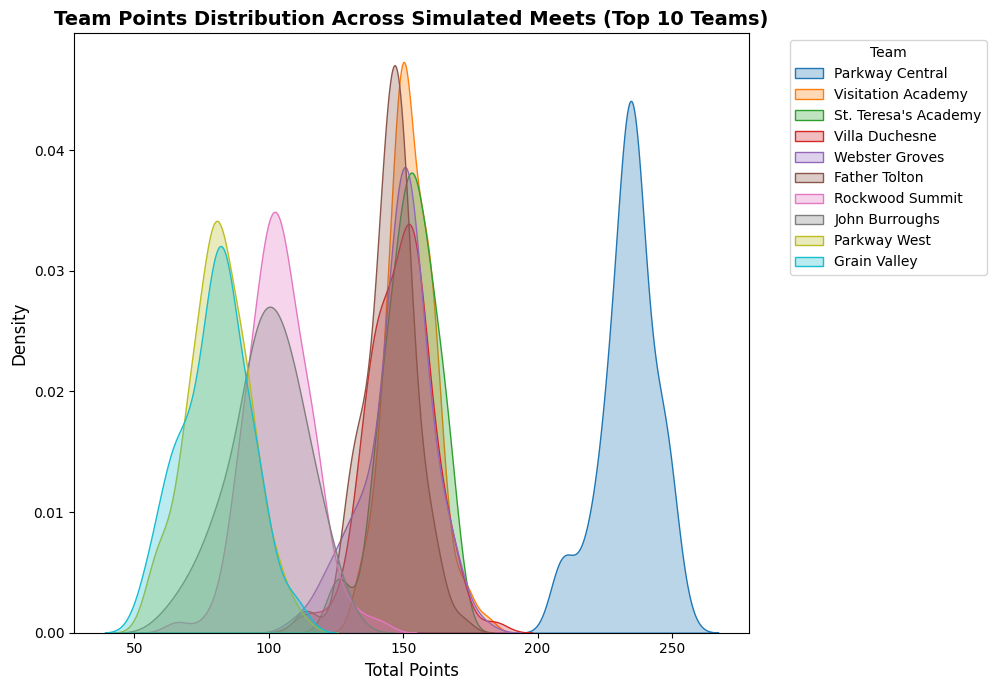

In [269]:
plt.figure(figsize=(12, 7))

# Plot top 10 teams by mean score for clarity
top_teams = team_stats.head(10).index
df_top = df_scores[df_scores['team'].isin(top_teams)]

# Create plot WITHOUT hue initially
palette = sns.color_palette('tab10', n_colors=len(top_teams))

# Plot each team individually with label
for i, team in enumerate(top_teams):
    team_data = df_top[df_top['team'] == team]
    sns.kdeplot(data=team_data, x='points', 
                fill=True, alpha=0.3, 
                color=palette[i],
                label=team)

plt.title("Team Points Distribution Across Simulated Meets (Top 10 Teams)", 
            fontsize=14, fontweight='bold')
plt.xlabel("Total Points", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust right margin for legend
plt.show()

/var/folders/jb/htz2wz0x3s93z17kl82cw22c0000gn/T/ipykernel_65182/4199871721.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_sorted, x='team', y='points', palette='Set2')


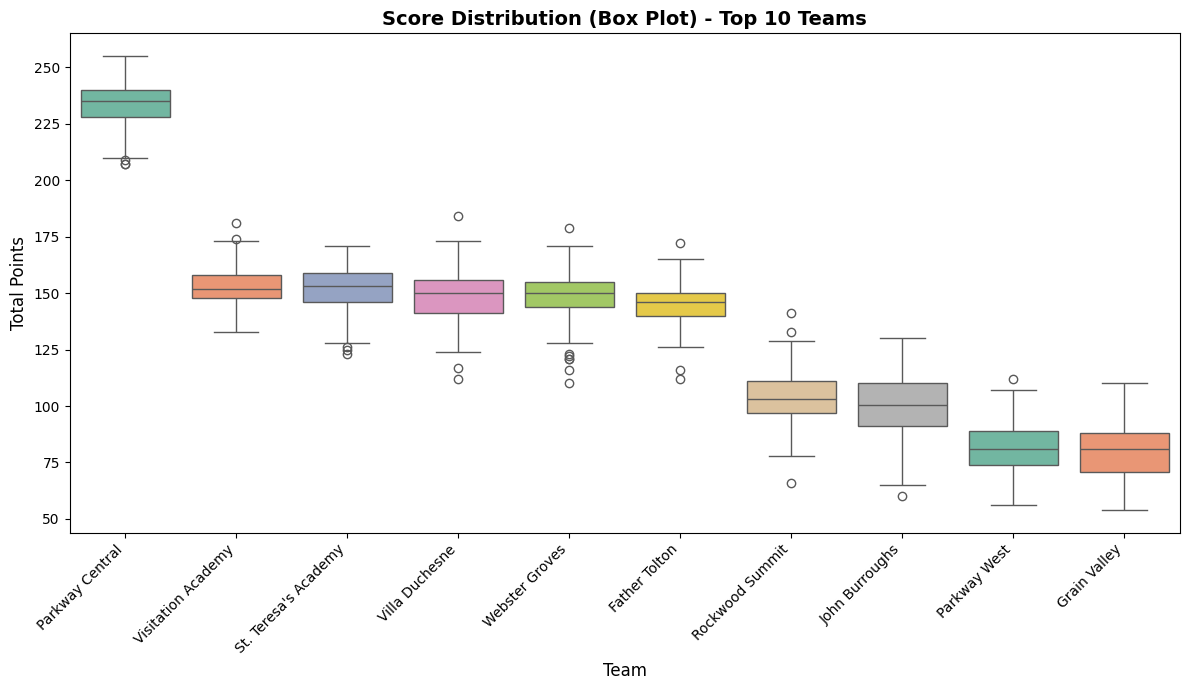

In [270]:
# Box plot showing score distributions for top teams
plt.figure(figsize=(12, 7))
top_teams_list = team_stats.head(10).index.tolist()
df_top_sorted = df_scores[df_scores['team'].isin(top_teams_list)].copy()

# Order by mean score
team_order = team_stats.head(10).index.tolist()
df_top_sorted['team'] = pd.Categorical(df_top_sorted['team'], categories=team_order, ordered=True)

sns.boxplot(data=df_top_sorted, x='team', y='points', palette='Set2')
plt.title("Score Distribution (Box Plot) - Top 10 Teams", fontsize=14, fontweight='bold')
plt.xlabel("Team", fontsize=12)
plt.ylabel("Total Points", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [271]:
# Summary table combining stats and win probabilities
winners = df_scores.loc[df_scores.groupby('simulation_id')['points'].idxmax()]
win_counts = winners['team'].value_counts()
win_probs = (win_counts / len(df_scores['simulation_id'].unique()) * 100).round(2)

win_prob_df = pd.DataFrame({
    'team': win_probs.index,
    'wins': win_counts.values,
    'win_probability_%': win_probs.values
}).sort_values('win_probability_%', ascending=False)

summary = team_stats.merge(
    win_prob_df.set_index('team')[['win_probability_%', 'wins']],
    left_index=True,
    right_index=True,
    how='left'
).fillna(0)

summary = summary.sort_values('mean', ascending=False)
print("Complete Team Summary (sorted by average points):")
summary.head(15)

Complete Team Summary (sorted by average points):


,mean,std,min,max,median,q25,q75,win_probability_%,wins
team,,,,,,,,,
Parkway Central,233.7,10.3,207,255,235.0,228.0,240.0,100.0,100.0
Visitation Academy,152.8,8.7,133,181,152.0,148.0,158.0,0.0,0.0
St. Teresa's Academy,152.2,10.2,123,171,153.0,146.0,159.0,0.0,0.0
Villa Duchesne,148.8,11.7,112,184,150.0,141.0,156.0,0.0,0.0
Webster Groves,148.2,12.5,110,179,150.0,143.8,155.0,0.0,0.0
Father Tolton,144.9,9.7,112,172,146.0,140.0,150.0,0.0,0.0
Rockwood Summit,103.7,11.7,66,141,103.0,96.8,111.0,0.0,0.0
John Burroughs,99.2,14.3,60,130,100.5,91.0,110.0,0.0,0.0
Parkway West,81.3,11.5,56,112,81.0,74.0,89.0,0.0,0.0


In [272]:
# Podium probabilities (top 3 finish)
team_totals = df_scores.groupby(['simulation_id', 'team'])['points'].sum().reset_index()

# Rank teams within each simulation
team_totals['rank'] = team_totals.groupby('simulation_id')['points'].rank(ascending=False, method='min')
team_totals['on_podium'] = (team_totals['rank'] <= 3).astype(int)

podium_probs = team_totals.groupby('team').agg({
    'on_podium': 'mean',
    'rank': 'mean'
}).round(3)
podium_probs.columns = ['podium_probability', 'avg_rank']
podium_probs = podium_probs.sort_values('podium_probability', ascending=False)

print("Podium Finish Probabilities:")
podium_probs.head(15)


Podium Finish Probabilities:


,podium_probability,avg_rank
team,,
Parkway Central,1.00,1.00
Visitation Academy,0.53,3.52
St. Teresa's Academy,0.52,3.61
Webster Groves,0.43,4.00
Villa Duchesne,0.37,4.03
Father Tolton,0.23,4.56
Parkway West,0.00,10.18
Rockwood Summit,0.00,7.74
Principia,0.00,33.31


### 6.5 Full run and export

Run more simulations (e.g. 1000) and export **`df_scores`** and **`df_results`** to CSV for reports and the Streamlit explorer.


In [273]:
# Run Monte Carlo to get both team scores and individual swimmer results (same function)
n_sims = 670
df_scores, df_results = run_monte_carlo(result_df, assignments, relay_assignments, n_sims=n_sims)

print(f"Collected results from {df_results['simulation_id'].nunique()} simulations")
print(f"Total swimmer-event results: {len(df_results)}")
print(f"Individual events: {len(df_results[df_results['is_relay']==False])}")
print(f"Relay events: {len(df_results[df_results['is_relay']==True])}")
print(f"\nColumns in df_results: {df_results.columns.tolist()}")
print(f"\nsample rows:")
df_results.sample(10)


Running Monte Carlo simulations: 100%|██████████| 670/670 [01:27<00:00,  7.64it/s]


Collected results from 670 simulations
Total swimmer-event results: 276040
Individual events: 171520
Relay events: 104520

Columns in df_results: ['name', 'team', 'event', 'time', 'state', 'is_relay', 'place', 'points', 'simulation_id']

sample rows:


,name,team,event,time,state,is_relay,place,points,simulation_id
45410,Kyla Potter,Webb City,100 Fly,66.967567,Average,False,27,0,110
82210,Kate Punnewaert,Nerinx Hall,200 IM,128.943300,Good,False,4,15,199
184510,St. Dominic,St. Dominic,400 Free Relay,273.362760,Bad,True,44,0,447
84096,Kelly Frank,Notre Dame de Sion,100 Breast,73.766081,Good,False,17,0,204
106060,Monett,Monett,200 Free Relay,107.752006,Bad,True,17,0,257
186740,Abigail Conrardy,Visitation Academy,100 Free,55.841863,Bad,False,9,9,453
76280,Ronnie Benford,Platte County,100 Breast,76.206336,Average,False,29,0,185
92815,Kenadie Johnson,Parkway Central,100 Free,57.793157,Good,False,20,0,225
85641,Ella Chrun,Ursuline Academy,50 Free,25.493512,Good,False,10,7,207
66143,Molly Moriarty,Visitation Academy,200 IM,131.317727,Good,False,5,14,160


### Export swimmer results for the interactive explorer

Run the cell below to save simulation results so you can generate a PDF report with `python generate_report.py`.

Run the cell below to export individual swimmer results, then launch the Streamlit app:
```bash
streamlit run swimmer_explorer.py
```

In [274]:
# Export swimmer results for the Streamlit explorer
df_results.to_csv('class1_swimmer_results.csv.gz', index=False, compression='gzip')
print(f"Saved class1_swimmer_results.csv.gz ({len(df_results):,} rows)")
print("Launch the explorer with: streamlit run swimmer_explorer.py")

# Export team scores for report and Streamlit app (gzip = much smaller files)
df_scores.to_csv('class1_team_scores.csv.gz', index=False, compression='gzip')
print("Saved class1_team_scores.csv.gz & class1_simulation_results.csv.gz — run: python generate_report.py | streamlit run swimmer_explorer.py")

# Tip: Fewer simulations (e.g. n_sims=500 or 1000) also reduces file size. 500–1000 is often enough for stable estimates.


Saved class1_swimmer_results.csv.gz (276,040 rows)
Launch the explorer with: streamlit run swimmer_explorer.py
Saved class1_team_scores.csv.gz & class1_simulation_results.csv.gz — run: python generate_report.py | streamlit run swimmer_explorer.py


In [275]:
# show simple mean scores (using df_scores from run_monte_carlo)
team_means = df_scores.groupby('team')['points'].mean().sort_values(ascending=False)
res = list(team_means.head(10).items())

print("avg points per school across all simulations")
print("=" * 45)
print(f"{'Rank':<5} {'School':<25} {'Avg Points':>12}")
print("-" * 45)
for rank, (school, points) in enumerate(res, 1):
    print(f"{rank:>2}.  {school:25} {points:>6.1f} points")

avg points per school across all simulations
Rank  School                      Avg Points
---------------------------------------------
 1.  Parkway Central            233.6 points
 2.  Visitation Academy         153.6 points
 3.  St. Teresa's Academy       150.3 points
 4.  Villa Duchesne             148.8 points
 5.  Webster Groves             148.4 points
 6.  Father Tolton              145.9 points
 7.  Rockwood Summit            104.2 points
 8.  John Burroughs             100.2 points
 9.  Parkway West                81.7 points
10.  Grain Valley                80.6 points


/var/folders/jb/htz2wz0x3s93z17kl82cw22c0000gn/T/ipykernel_65182/2476439209.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


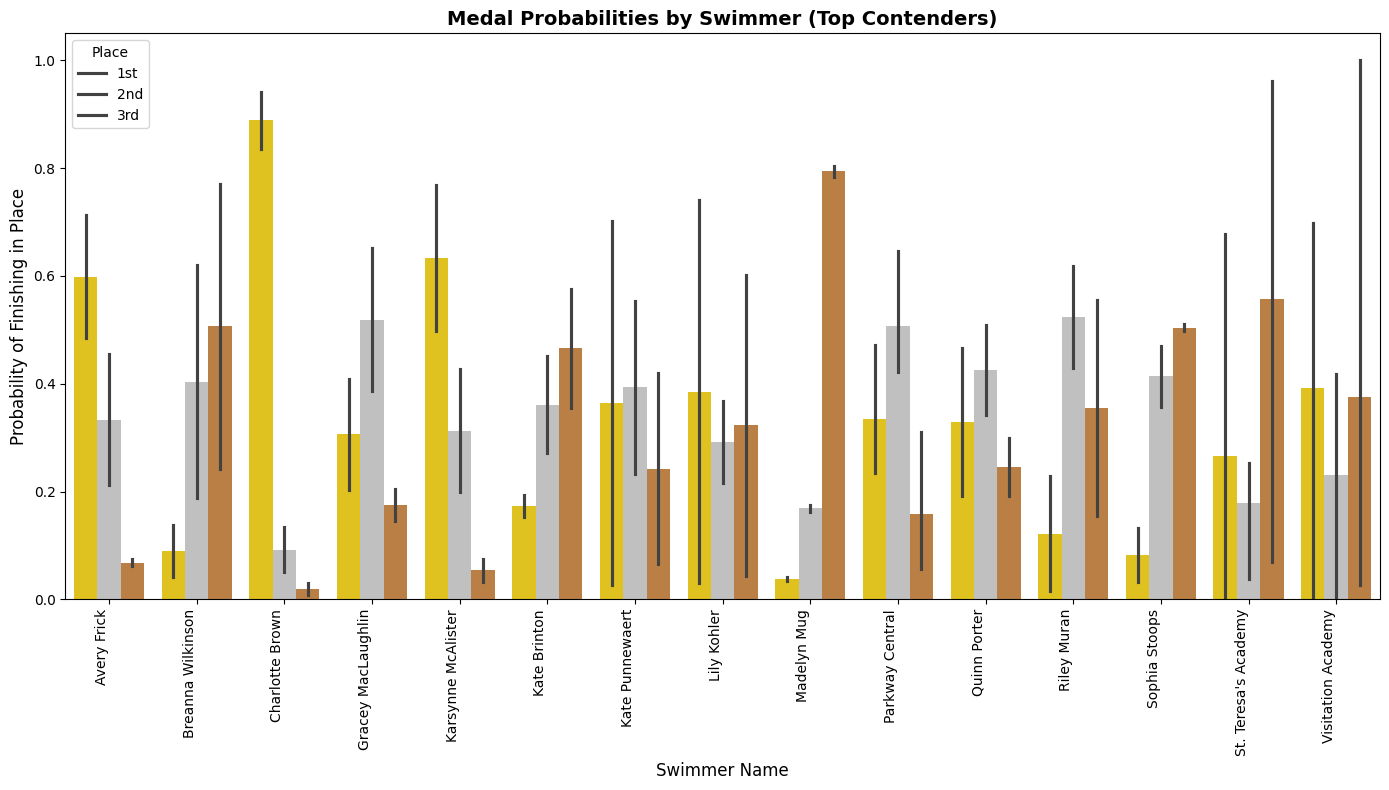

In [276]:
# Calculate medal probabilities (top 3 places)
# Note: 'name' is the column name from simulate_one_meet, not 'swimmer_name'
medal_probs = (
    df_results[df_results['place'] <= 3]
    .groupby(['name', 'event', 'place'])
    .size()
    .reset_index(name='count')
    .groupby(['name', 'event'])
    .apply(lambda x: pd.Series({
        'place_1': (x[x['place'] == 1]['count'].sum() / x['count'].sum()) if (x['place'] == 1).any() else 0,
        'place_2': (x[x['place'] == 2]['count'].sum() / x['count'].sum()) if (x['place'] == 2).any() else 0,
        'place_3': (x[x['place'] == 3]['count'].sum() / x['count'].sum()) if (x['place'] == 3).any() else 0,
        'total_podium': x['count'].sum() / df_results['simulation_id'].nunique()
    }))
    .reset_index()
)

# Melt to long format for easier plotting
medal_probs_long = medal_probs.melt(
    id_vars=['name', 'event'],
    value_vars=['place_1', 'place_2', 'place_3'],
    var_name='place',
    value_name='probability'
)
medal_probs_long['place'] = medal_probs_long['place'].str.replace('place_', '').astype(int)

# Filter to swimmers with meaningful podium probabilities (at least 1% in any simulation)
top_medal_contenders = medal_probs[medal_probs['total_podium'] > 0.01].sort_values('total_podium', ascending=False)
top_names = top_medal_contenders['name'].head(20).unique()

medal_probs_filtered = medal_probs_long[medal_probs_long['name'].isin(top_names)]

plt.figure(figsize=(14, 8))
sns.barplot(data=medal_probs_filtered, x='name', y='probability', hue='place', palette={1: 'gold', 2: 'silver', 3: '#CD7F32'})
plt.title("Medal Probabilities by Swimmer (Top Contenders)", fontsize=14, fontweight='bold')
plt.xticks(rotation=90, ha='right')
plt.ylabel("Probability of Finishing in Place", fontsize=12)
plt.xlabel("Swimmer Name", fontsize=12)
plt.legend(title='Place', labels=['1st', '2nd', '3rd'])
plt.tight_layout()
plt.show()

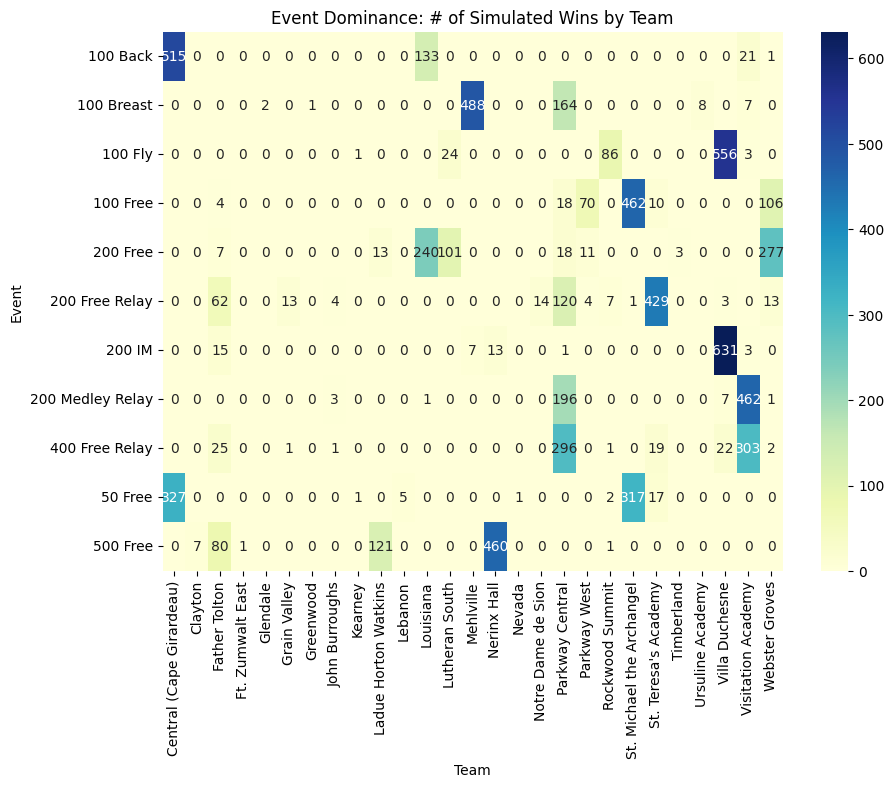

In [277]:
event_strength = (
    df_results[df_results['place'] == 1]
    .groupby(['event', 'team'])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(10,7))
sns.heatmap(event_strength, cmap="YlGnBu", annot=True, fmt='d')
plt.title("Event Dominance: # of Simulated Wins by Team")
plt.xlabel("Team")
plt.ylabel("Event")
plt.show()

### 6.7 Relay analysis

Relays are scored with **double** points. Analyze relay win and medal (top 3) probabilities by team and event.


### 6.6 Individual swimmer & medal probabilities

From `df_results`, compute medal (top 3) and event-strength probabilities per swimmer/event.


In [278]:
# Relay win probabilities (which team wins each relay event most often)
# Check if is_relay column exists, if not infer from event names
if 'is_relay' in df_results.columns:
    relay_results = df_results[df_results['is_relay'] == True].copy()
else:
    # Infer relays from event names containing "Relay"
    print("Note: 'is_relay' column not found. Inferring relays from event names...")
    df_results['is_relay'] = df_results['event'].str.contains('Relay', case=False, na=False)
    relay_results = df_results[df_results['is_relay'] == True].copy()

if len(relay_results) == 0:
    print("⚠️ No relay results found. Please re-run the Monte Carlo simulation after updating the code.")
    print("Relay events should now be included in result_df with is_relay=True")
else:
    relay_win_probs = (
        relay_results[relay_results['place'] == 1]
        .groupby(['event', 'team'])
        .size()
        .reset_index(name='wins')
        .groupby('event')
        .apply(lambda x: x.assign(win_probability=x['wins'] / x['wins'].sum() * 100))
        .reset_index(drop=True)
        .sort_values(['event', 'win_probability'], ascending=[True, False])
    )

    print("Relay Win Probabilities by Event and Team:")
    print(f"Total simulations: {df_results['simulation_id'].nunique()}")
    relay_win_probs.head(20)


Relay Win Probabilities by Event and Team:
Total simulations: 670


/var/folders/jb/htz2wz0x3s93z17kl82cw22c0000gn/T/ipykernel_65182/3678600167.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(win_probability=x['wins'] / x['wins'].sum() * 100))


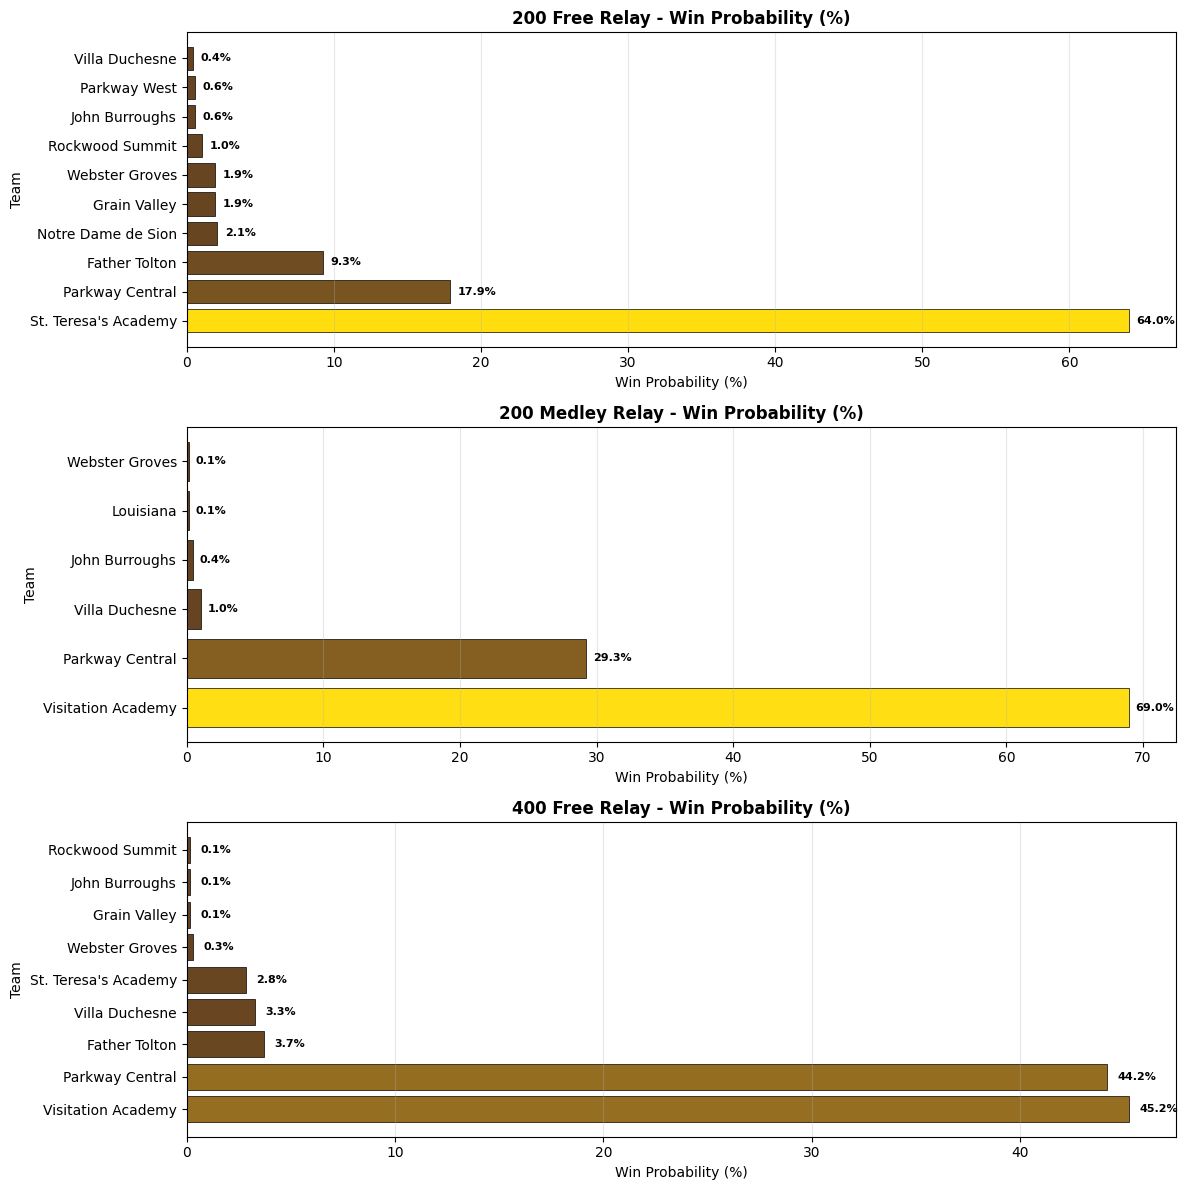

In [279]:
# Visualize relay win probabilities
relay_events = relay_results['event'].unique()
fig, axes = plt.subplots(len(relay_events), 1, figsize=(12, 4*len(relay_events)))
if len(relay_events) == 1:
    axes = [axes]

for idx, event in enumerate(relay_events):
    event_data = relay_win_probs[relay_win_probs['event'] == event].head(10)
    if len(event_data) > 0:
        # Create gradient color from brown (low prob) to gold (high prob)
        probs = event_data['win_probability']
        
        # Normalize probabilities for color mapping (0-1 range)
        norm_probs = probs / 100
        
        # Create color gradient: brown to gold
        colors = []
        for prob in norm_probs:
            if prob > 0.5:  # More likely to win (gold to yellow)
                # Interpolate from goldenrod to gold based on probability
                weight = min(1.0, (prob - 0.5) * 2)  # Scale from 0.5-1 to 0-1
                r = 255
                g = 215 + (20 * weight)  # From 215 to 235
                b = 0 + (50 * weight)    # From 0 to 50
                colors.append((r/255, g/255, b/255))
            else:  # Less likely to win (brown shades)
                weight = prob * 2  # Scale 0-0.5 to 0-1
                r = 101 + (54 * weight)   # From 101 to 155
                g = 67 + (48 * weight)    # From 67 to 115
                b = 33                    # Brown stays constant
                colors.append((r/255, g/255, b/255))
        
        axes[idx].barh(event_data['team'], probs, color=colors, edgecolor='black', linewidth=0.5)
        axes[idx].set_title(f"{event} - Win Probability (%)", fontsize=12, fontweight='bold')
        axes[idx].set_xlabel("Win Probability (%)", fontsize=10)
        axes[idx].set_ylabel("Team", fontsize=10)
        axes[idx].grid(axis='x', alpha=0.3)
        
        # Add probability labels on bars
        for i, (bar, prob) in enumerate(zip(axes[idx].patches, probs)):
            width = bar.get_width()
            axes[idx].text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                          f'{prob:.1f}%', va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

In [280]:
# Relay medal probabilities (top 3 places)
if len(relay_results) > 0:
    relay_medal_probs = (
        relay_results[relay_results['place'] <= 3]
        .groupby(['event', 'team', 'place'])
        .size()
        .reset_index(name='count')
        .groupby(['event', 'team'])
        .apply(lambda x: pd.Series({
            'place_1': (x[x['place'] == 1]['count'].sum() / x['count'].sum()) if (x['place'] == 1).any() else 0,
            'place_2': (x[x['place'] == 2]['count'].sum() / x['count'].sum()) if (x['place'] == 2).any() else 0,
            'place_3': (x[x['place'] == 3]['count'].sum() / x['count'].sum()) if (x['place'] == 3).any() else 0,
            'total_podium': x['count'].sum() / df_results['simulation_id'].nunique()
        }))
        .reset_index()
    )

    # Melt to long format
    relay_medal_probs_long = relay_medal_probs.melt(
        id_vars=['event', 'team'],
        value_vars=['place_1', 'place_2', 'place_3'],
        var_name='place',
        value_name='probability'
    )
    relay_medal_probs_long['place'] = relay_medal_probs_long['place'].str.replace('place_', '').astype(int)

    # Filter to top contenders (at least 5% podium probability)
    top_relay_contenders = relay_medal_probs[relay_medal_probs['total_podium'] > 0.05].sort_values('total_podium', ascending=False)

    print("Relay Medal Probabilities (Top Contenders):")
    print(f"Showing teams with at least 5% podium probability")
    top_relay_contenders.head(20)
else:
    print("No relay results found. Please re-run the Monte Carlo simulation.")


Relay Medal Probabilities (Top Contenders):
Showing teams with at least 5% podium probability


/var/folders/jb/htz2wz0x3s93z17kl82cw22c0000gn/T/ipykernel_65182/3221821452.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


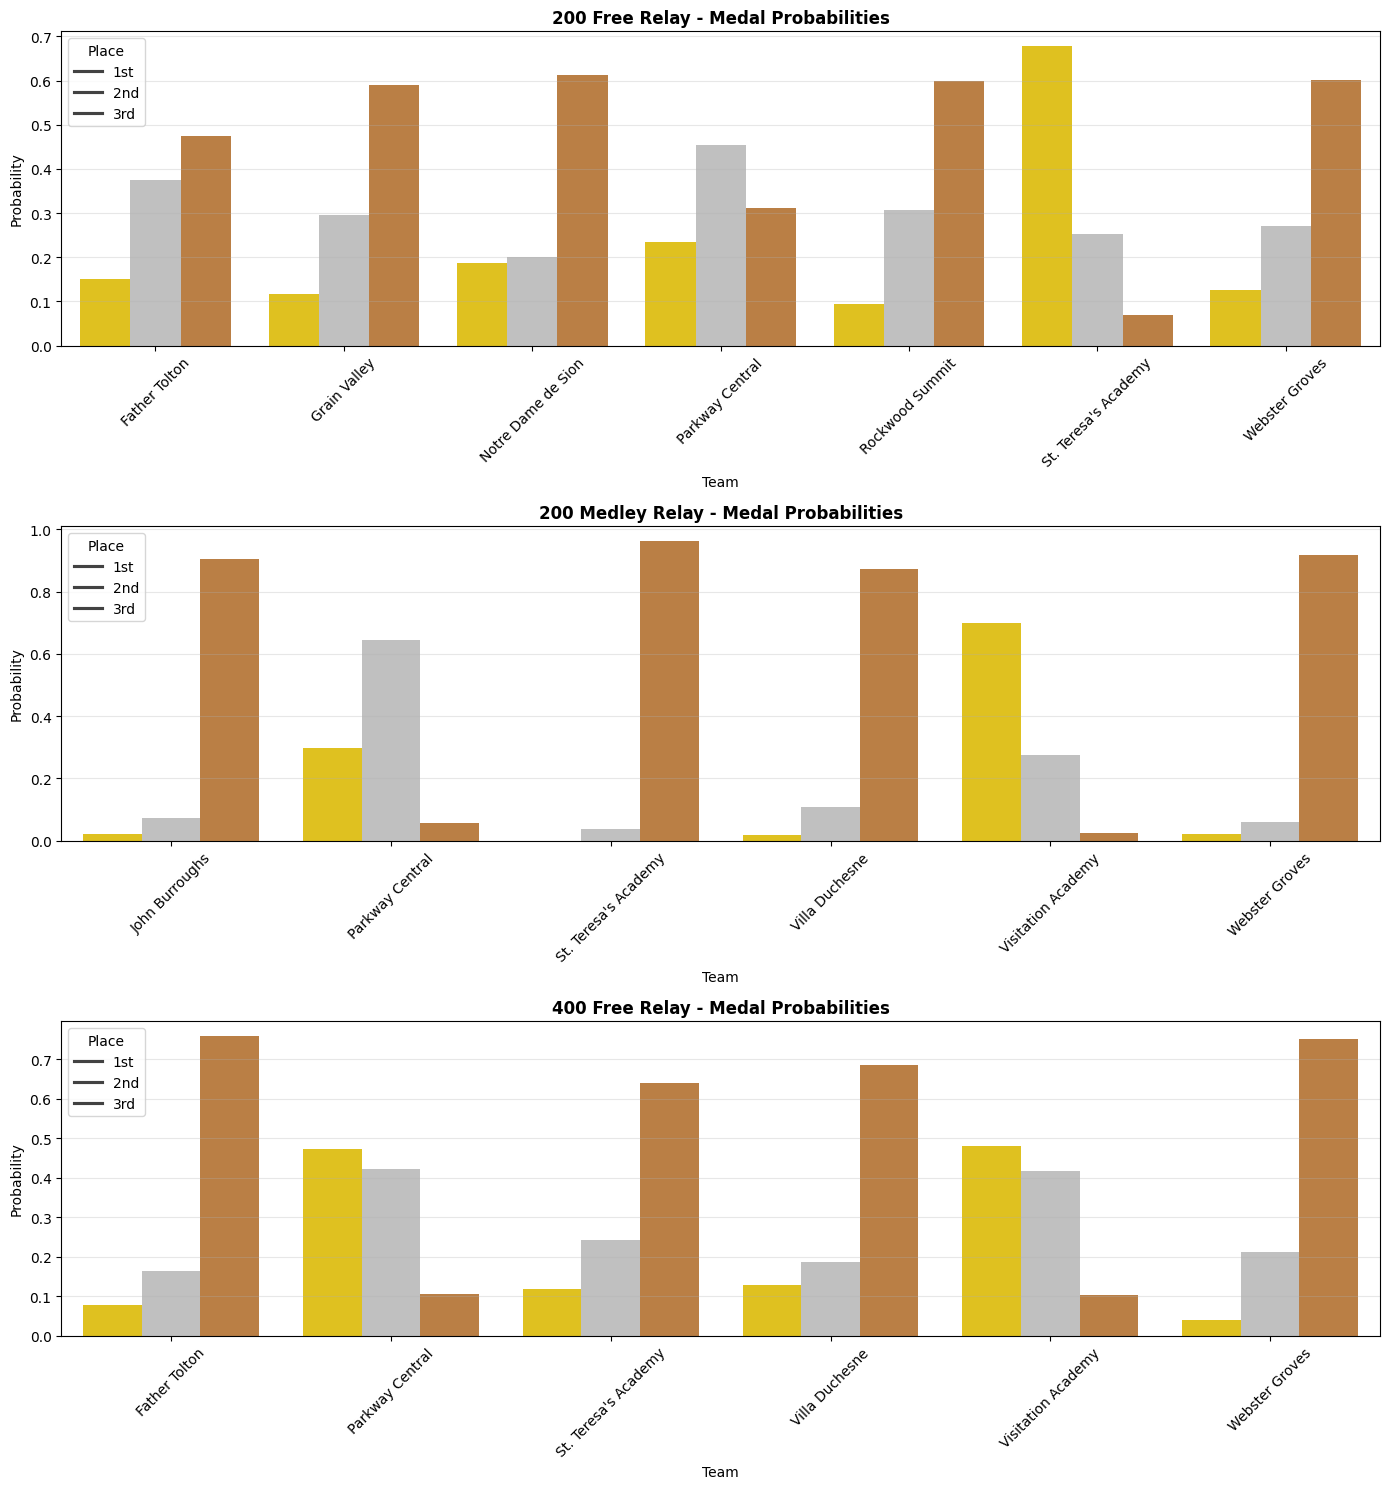

In [281]:
# Visualize relay medal probabilities
if len(relay_results) > 0 and 'relay_medal_probs_long' in locals() and 'top_relay_contenders' in locals():
    relay_events = relay_results['event'].unique()
    if len(relay_events) > 0:
        fig, axes = plt.subplots(len(relay_events), 1, figsize=(14, 5*len(relay_events)))
        if len(relay_events) == 1:
            axes = [axes]

        for idx, event in enumerate(relay_events):
            event_contenders = top_relay_contenders[top_relay_contenders['event'] == event]['team'].head(10)
            if len(event_contenders) > 0:
                event_data = relay_medal_probs_long[
                    (relay_medal_probs_long['event'] == event) & 
                    (relay_medal_probs_long['team'].isin(event_contenders))
                ]
                
                if len(event_data) > 0:
                    sns.barplot(data=event_data, x='team', y='probability', hue='place', 
                               palette={1: 'gold', 2: 'silver', 3: '#CD7F32'}, ax=axes[idx])
                    axes[idx].set_title(f"{event} - Medal Probabilities", fontsize=12, fontweight='bold')
                    axes[idx].set_xlabel("Team", fontsize=10)
                    axes[idx].set_ylabel("Probability", fontsize=10)
                    axes[idx].tick_params(axis='x', rotation=45)
                    axes[idx].legend(title='Place', labels=['1st', '2nd', '3rd'])
                    axes[idx].grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()
    else:
        print("No relay events found to visualize")
else:
    print("No relay medal data available. re-run the Monte Carlo simulation.")


In [282]:
individual_points = (
    df_results[df_results['is_relay'] == False]
    .groupby(['simulation_id', 'team'])['points']
    .sum()
    .reset_index()
    .rename(columns={'points': 'individual_points'})
)

# Relay points by team
relay_points = (
    relay_results.groupby(['simulation_id', 'team'])['points']
    .sum()
    .reset_index()
    .rename(columns={'points': 'relay_points'})
)

# Combine individual and relay points
total_points = individual_points.merge(
    relay_points,
    on=['simulation_id', 'team'],
    how='outer'
).fillna(0)

total_points['total_points'] = total_points['individual_points'] + total_points['relay_points']

# Summary statistics by team
team_breakdown = (
    total_points.groupby('team')
    .agg({
        'individual_points': ['mean', 'std'],
        'relay_points': ['mean', 'std'],
        'total_points': ['mean', 'std', 'min', 'max']
    })
    .round(1)
)

# Flatten column names
team_breakdown.columns = [
    'avg_individual_pts', 'std_individual_pts',
    'avg_relay_pts', 'std_relay_pts',
    'avg_total_pts', 'std_total_pts', 'min_total_pts', 'max_total_pts'
]

team_breakdown = team_breakdown.sort_values('avg_total_pts', ascending=False)

### 6.8 Team points breakdown

Break down team points into individual vs relay contribution (relays count double).


In [283]:
print("Team Points Breakdown: Individual Events + Relays")
print("\nTop 15 teams by average total points:")
team_breakdown.head(15)

Team Points Breakdown: Individual Events + Relays

Top 15 teams by average total points:


,avg_individual_pts,std_individual_pts,avg_relay_pts,std_relay_pts,avg_total_pts,std_total_pts,min_total_pts,max_total_pts
team,,,,,,,,
Parkway Central,129.1,8.1,104.5,7.0,233.6,10.6,191.0,267.0
Visitation Academy,76.3,5.3,77.3,7.4,153.6,9.3,123.0,189.0
St. Teresa's Academy,58.8,6.3,91.5,8.8,150.3,10.6,105.0,179.0
Villa Duchesne,77.0,6.5,71.9,9.3,148.8,11.3,99.0,184.0
Webster Groves,72.6,5.6,75.7,10.3,148.4,11.5,102.0,180.0
Father Tolton,81.8,6.3,64.1,7.3,145.9,9.7,113.0,181.0
Rockwood Summit,58.0,4.8,46.2,11.5,104.2,12.6,59.0,145.0
John Burroughs,33.9,7.3,66.3,11.1,100.2,13.1,44.0,135.0
Parkway West,46.0,5.2,35.8,9.9,81.7,11.6,47.0,116.0


In [284]:
team_breakdown['relay_contribution_%'] = (
    (team_breakdown['avg_relay_pts'] / team_breakdown['avg_total_pts'] * 100).round(1)
)
print("\nRelay contribution as percentage of total points:")
team_breakdown[['avg_individual_pts', 'avg_relay_pts', 'avg_total_pts', 'relay_contribution_%']].head(15)


Relay contribution as percentage of total points:


,avg_individual_pts,avg_relay_pts,avg_total_pts,relay_contribution_%
team,,,,
Parkway Central,129.1,104.5,233.6,44.7
Visitation Academy,76.3,77.3,153.6,50.3
St. Teresa's Academy,58.8,91.5,150.3,60.9
Villa Duchesne,77.0,71.9,148.8,48.3
Webster Groves,72.6,75.7,148.4,51.0
Father Tolton,81.8,64.1,145.9,43.9
Rockwood Summit,58.0,46.2,104.2,44.3
John Burroughs,33.9,66.3,100.2,66.2
Parkway West,46.0,35.8,81.7,43.8


# THE END!

I HOPE WE WIN!